## TimeSHAP

Used on Aachen dataset

In [3]:
import timeshap

# Import necessary functions and modules from the script
from LSTM_Model_Training import (
    get_config,
    preprocess_aachen_dataset,
    build_model,
    plot_training_history,
    plot_predictions_vs_actual,
    plot_residuals,
    explain_with_shap,
    save_model_structure_and_weights,
    load_model_structure_and_weights,
    get_unique_model_name
)

import pandas as pd
import tensorflow as tf


In [ ]:
# Step 1: Load configuration
config = get_config()

# Step 2: Preprocess the Aachen dataset
data_path = "/Users/sigurdgjerdingen/Student/Master kode/Master_Herstad-Gjerdingen/Aachen/Degradation_Prediction_Dataset_ISEA.mat"
aachen_data = preprocess_aachen_dataset(
    data_path,
    test_cell_count=3,
    random_state=42,
    phase=None,
    log_transform=False,
)

# Extract the preprocessed data
X_train_lstm = aachen_data["X_train"]
X_val_lstm = aachen_data["X_val"]
X_test_lstm = aachen_data["X_test"]
y_train = aachen_data["y_train"]
y_val = aachen_data["y_val"]
y_test = aachen_data["y_test"]
y_max = aachen_data["y_max"]

# Step 3: Define model name for loading or saving
model_name = "Aachen/Models/model_20250131_124416"
#model_name = "Aachen/Models/model_20250127_135003"  # Update as needed

if model_name is None:
    model_name = get_unique_model_name()

# Step 4: Load or train the model
try:
    print("Attempting to load pre-trained model...")
    model = load_model_structure_and_weights(model_name)
    print("Pre-trained model loaded successfully.")
except FileNotFoundError:
    print("No pre-trained model found. Training a new model...")

    # Build the model
    model = build_model(X_train_lstm.shape[1:], config)

    # Define callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=config["patience"], restore_best_weights=True
        )
    ]

    # Train the model
    history = model.fit(
        X_train_lstm, y_train,
        validation_data=(X_val_lstm, y_val),
        epochs=config["epochs"],
        batch_size=config["batch_size"],
        verbose=1,
        callbacks=callbacks
    )

    # Save the best model after training
    save_model_structure_and_weights(model, model_name)
    print(f"New model saved as {model_name}")

    # Plot training history
    plot_training_history(history)

Attempting to load pre-trained model...
Checking for model files in the following paths:
Structure file: Aachen/Models/model_20250131_124416.structure.json
Weights file: Aachen/Models/model_20250131_124416.weights.h5
Contents of directory 'Aachen/Models':
['model_20250127_135003.structure.json', 'model_20250131_124416.weights.h5', 'model_20250127_135003.weights.h5', 'model_20250128_130021.structure.json', 'model_20250128_130021.weights.h5', 'model_20250131_123220.structure.json', 'model_20250131_124416.structure.json', 'model_20250131_123220.weights.h5']
Model loaded from Aachen/Models/model_20250131_124416.structure.json and Aachen/Models/model_20250131_124416.weights.h5
Pre-trained model loaded successfully.


In [10]:
# Step 5: Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test_lstm, y_test, verbose=1)
print(f"\nTest Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

# Step 6: Make predictions on the test set
y_pred = model.predict(X_test_lstm)

# Rescale predictions and test data back to the original range
y_pred_rescaled = y_pred.flatten() * y_max
y_test_rescaled = y_test * y_max

# Compare actual and predicted values
results = pd.DataFrame({
    "Actual RUL80": y_test_rescaled,
    "Predicted RUL80": y_pred_rescaled
})
print(results.head())

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.8971e-04 - mae: 0.0180

Test Loss: 0.0009450705256313086
Test MAE: 0.024175753816962242
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
   Actual RUL80  Predicted RUL80
0        1060.0      1029.755249
1        1055.0      1029.259155
2        1050.0      1026.125732
3        1045.0      1021.070496
4        1040.0      1014.818420


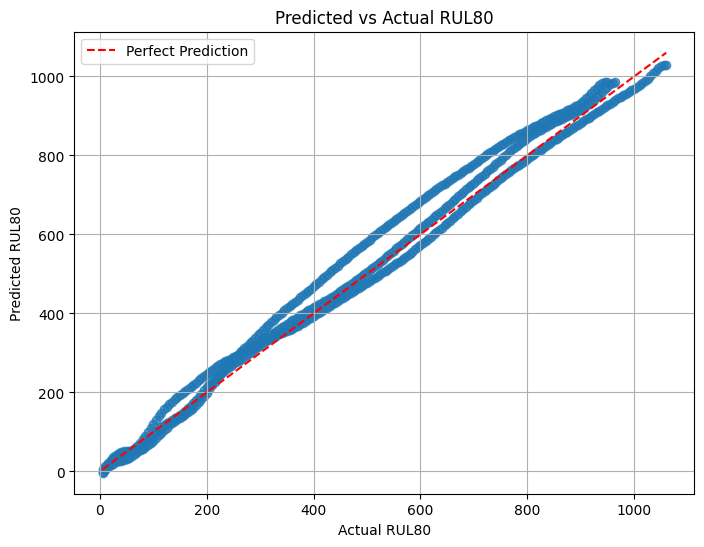

In [11]:
# Step 7: Visualize predictions and residuals
plot_predictions_vs_actual(y_test_rescaled, y_pred_rescaled)
